In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
import random
import shutil
import os
from datetime import datetime

import numpy as np
import cv2
from imutils import paths, resize
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import classification_report
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.model_selection import train_test_split
import pandas as pd
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions

import tensorflow_datasets as tfds
from tensorflow import keras
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, BatchNormalization, Conv2D, MaxPooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D, AveragePooling2D
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.regularizers import l2
from tensorflow.keras import backend as K
from tensorflow.keras.layers import add
from keras.preprocessing.image import ImageDataGenerator
from numpy import expand_dims


import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow.keras.applications
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from tensorflow.data import AUTOTUNE
from tensorflow.keras import Sequential
from tensorflow.keras.layers.experimental import preprocessing
from imutils import paths

In [2]:
seed = 42
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)

In [3]:
image_height = 224
image_width = 224
image_depth = 3 
channel_dim = -1 # channels_last
input_shape = (image_height, image_width, image_depth)
input_shape_64 = (64, 64, 3)

In [4]:
def make_confusion_matrix(cfm):
    off_diag_mask = np.eye(*cfm.shape, dtype=bool)
    vmin = np.min(cfm)
    vmax = np.max(cfm)

    #Plotting the confusion matrix
    plt.figure(figsize=(6,5))
    sns.heatmap(cfm, annot=True, fmt='g', mask=~off_diag_mask, cmap='Blues', vmin=vmin, vmax=vmax)
    sns.heatmap(cfm, annot=True, fmt='g', mask=off_diag_mask, vmin=vmin, vmax=vmax)

    plt.title('Predicted Values')
    plt.ylabel('Actal Values')

    plt.show()

## Section 2: Loading and Preprocessing Data

### Creating the dataset directory

This directory will contain all the folders each for one class or category.

In [5]:
try:
    shutil.rmtree("drv_lc_detection")
except OSError as e:
    print("Error: %s - %s." % (e.filename, e.strerror))

In [6]:
dv_image_paths = list(paths.list_images("data/drivers_licence"))
pass_image_paths = list(paths.list_images("data/passport"))

### Building labels from Data Directory name

I am building the labels list for each image file in the loaded image path.

In [7]:
img_locations = []
img_categories = []

    
for path in dv_image_paths:
    category = path.split(os.path.sep)[-2]
    img_locations.append(path)
    img_categories.append(category)
    
for path in pass_image_paths:
    category = path.split(os.path.sep)[-2]
    img_locations.append(path)
    img_categories.append(category)

### Showing image locations and image labels in Pandas dataframe

In [8]:
img_locations_df = pd.DataFrame(img_locations, columns=["item"])
img_locations_df.sample(5)

,item
30,data/drivers_licence/31.png
0,data/drivers_licence/8.png
22,data/drivers_licence/27.png
31,data/drivers_licence/19.png
18,data/drivers_licence/22.png


In [9]:
img_categories_df = pd.DataFrame(img_categories, columns=["item"])
img_categories_df.sample(5)

,item
54,passport
30,drivers_licence
35,drivers_licence
29,drivers_licence
48,passport


### Split the dataset - test train split - train data - 80% test data - 20% 

In [10]:
(train_ds, test_X, train_lbl, test_Y) = train_test_split(np.array(img_locations), np.array(img_categories), test_size=0.20, 
                                                         random_state=42, 
                                                         shuffle=True, 
                                                         stratify=img_categories)

### Split the dataset - train validation split of remaining train data - train data - 80% validation data - 10% 

In [11]:
train_X, val_X, train_Y, val_Y = train_test_split(train_ds, train_lbl, test_size=0.10, random_state=42)

In [12]:
dim_dict = {
    'trn_data_shape' : [train_X.shape[0]],
    'trn_label_shape' : [train_Y.shape[0]],
    'val_data_shape' : [val_X.shape[0]],
    'val_labels_shape': [val_Y.shape[0]],
    'test_data_shape': [test_X.shape[0]],
    'test_label_shape': [test_Y.shape[0]]
}
df_dimensions = pd.DataFrame(dim_dict)
df_dimensions.head()

,trn_data_shape,trn_label_shape,val_data_shape,val_labels_shape,test_data_shape,test_label_shape
0,57,57,7,7,16,16


### Creating the test, train, validation directories and copying the image data from the training, validation and test dataset locations 

In [13]:
base_path = "drv_lc_detection"
os.mkdir(base_path)

### Create train, test and validations directories

In [14]:
# derive the training, validation, and testing directories
train_dir = os.path.sep.join([base_path, "training"])
os.mkdir(train_dir)

validation_dir = os.path.sep.join([base_path, "validation"])
os.mkdir(validation_dir)

test_dir = os.path.sep.join([base_path, "testing"])
os.mkdir(test_dir)

In [15]:
print(train_dir, validation_dir, test_dir)

drv_lc_detection/training drv_lc_detection/validation drv_lc_detection/testing


### Creating sub-directories for each category in train, test and validation dataset 

In [16]:
train_dv_dir = os.path.join(train_dir, 'drivers_licence')
os.mkdir(train_dv_dir)

train_ps_dir = os.path.join(train_dir, 'passport')
os.mkdir(train_ps_dir)

In [17]:
validation_dv_dir = os.path.join(validation_dir, 'drivers_licence')
os.mkdir(validation_dv_dir)

validation_ps_dir = os.path.join(validation_dir, 'passport')
os.mkdir(validation_ps_dir)

In [18]:
test_dv_dir = os.path.join(test_dir, 'drivers_licence')
os.mkdir(test_dv_dir)

test_ps_dir = os.path.join(test_dir, 'passport')
os.mkdir(test_ps_dir)

### Copy all the images from the source directory to their respective categoties directories inside the  training, validation and test directories

In [19]:
train_paths = {"drivers_licence": train_dv_dir,
               "passport": train_ps_dir,
              }

for training_details in zip(train_X, train_Y):
    src_path = training_details[0]
    file_name = src_path.split(os.path.sep)[-1]
    dst_path = train_paths[training_details[1]]+"/"+file_name
    shutil.copyfile(src_path, dst_path)

In [20]:
val_paths = {"drivers_licence": validation_dv_dir, 
             "passport": validation_ps_dir,
            }

for val_details in zip(val_X, val_Y):
    src_path = val_details[0]
    file_name = src_path.split(os.path.sep)[-1]
    dst_path = val_paths[val_details[1]]+"/"+file_name
    shutil.copyfile(src_path, dst_path)

In [21]:
test_paths = {"drivers_licence": test_dv_dir,
              "passport": test_ps_dir,
            }


for test_details in zip(test_X, test_Y):
    src_path = test_details[0]
    file_name = src_path.split(os.path.sep)[-1]
    dst_path = test_paths[test_details[1]]+"/"+file_name
    shutil.copyfile(src_path, dst_path)

### Resize the image (224 x 224)

In [22]:
def image_resizer(image, width=224, height=224):
    (img_height, img_width) = image.shape[:2]
    d_width = 0
    d_height = 0
    
    if img_width < img_height:
        image = resize(image, width=width, inter=cv2.INTER_AREA)
        d_height = int((image.shape[0] - height) / 2.0)
    else:
        image = resize(image, height=height, inter=cv2.INTER_AREA)
        d_width = int((image.shape[1] - width) / 2.0)

    (res_height, res_width) = image.shape[:2]
    image = image[d_height:res_height - d_height, d_width:res_width - d_width]
    return cv2.resize(image, (width, height), interpolation=cv2.INTER_AREA)

### Converting the image to array of floats to make an input of the Convnet model

In [23]:
def image_to_array(image):
    return img_to_array(image)

### Image Preprocess

In [24]:
def preprocess(image, image_height, image_width):
    image = image_resizer(image, image_height, image_width)
    image = image_to_array(image)
    return image

### Loading image from disk and preprocessing and transforming image

In [25]:
def image_loader(dir_name, image_height, image_width):
    image_paths = list(paths.list_images(dir_name))
    img_data = []
    img_labels = []
    for image_path in image_paths:
        image = cv2.imread(image_path)
        label = image_path.split(os.path.sep)[-2]
        image = preprocess(image, image_height, image_width)
        img_data.append(image)
        img_labels.append(label)
    return (np.array(img_data), np.array(img_labels))

In [ ]:
# def image_loader_64(dir_name):
#     image_paths = list(paths.list_images(dir_name))
#     img_data = []
#     img_labels = []
#     for image_path in image_paths:
#         image = cv2.imread(image_path)
#         label = image_path.split(os.path.sep)[-2]
#         image = preprocess(image, 64, 64)
#         img_data.append(image)
#         img_labels.append(label)
#     return (np.array(img_data), np.array(img_labels))

### Pre-processing training data

In [26]:
(trn_data, trn_labels) = image_loader("./drv_lc_detection/training", image_height, image_width)
trn_data = trn_data.astype("float") / 255.0

libpng warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50


In [27]:
print( f'Training data shape is : {trn_data.shape}')
print(f'Training labels shape is {trn_labels.shape}')      

Training data shape is : (57, 224, 224, 3)
Training labels shape is (57,)


In [28]:
trn_labels

array(['passport', 'passport', 'passport', 'passport', 'passport',
       'passport', 'passport', 'passport', 'passport', 'passport',
       'passport', 'passport', 'passport', 'passport', 'passport',
       'passport', 'passport', 'passport', 'passport', 'passport',
       'passport', 'passport', 'passport', 'passport', 'passport',
       'passport', 'drivers_licence', 'drivers_licence',
       'drivers_licence', 'drivers_licence', 'drivers_licence',
       'drivers_licence', 'drivers_licence', 'drivers_licence',
       'drivers_licence', 'drivers_licence', 'drivers_licence',
       'drivers_licence', 'drivers_licence', 'drivers_licence',
       'drivers_licence', 'drivers_licence', 'drivers_licence',
       'drivers_licence', 'drivers_licence', 'drivers_licence',
       'drivers_licence', 'drivers_licence', 'drivers_licence',
       'drivers_licence', 'drivers_licence', 'drivers_licence',
       'drivers_licence', 'drivers_licence', 'drivers_licence',
       'drivers_licence', 'drive

In [29]:
trn_labels_int = []
for label in trn_labels:
    if label == 'drivers_licence':
        trn_labels_int.append(1)
    else:
        trn_labels_int.append(0)

### convert the labels from integers to vectors - to use with categorical cross-entropy

In [30]:
train_lb_bin = tf.keras.utils.to_categorical(trn_labels_int, num_classes=2, dtype="int32")
# print( f'Training labels after vectorize : {train_lb_bin}')

### Preprocessing validation data

In [31]:
(val_data, val_labels) = image_loader("./drv_lc_detection/validation", image_height, image_width)
val_data = val_data.astype("float") / 255.0

In [32]:
print( f'Validation data shape is : {val_data.shape}')
print(f'validation labels shape is {val_labels.shape}')  

Validation data shape is : (7, 224, 224, 3)
validation labels shape is (7,)


In [33]:
val_labels_int = []
for label in val_labels:
    if label == 'drivers_licence':
        val_labels_int.append(1)
    else:
        val_labels_int.append(0)

In [34]:
val_lb_bin = tf.keras.utils.to_categorical(val_labels_int, num_classes=2, dtype="int32")
print( f'Validation labels after vectorize: {val_lb_bin}')

Validation labels after vectorize: [[1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [0 1]]


### Transforming the test data for generating predictions after model training

In [35]:
(tst_data, tst_labels) = image_loader("./drv_lc_detection/testing", image_height, image_width)
tst_data = tst_data.astype("float") / 255.0

In [70]:
tst_labels

array(['passport', 'passport', 'passport', 'passport', 'passport',
       'passport', 'passport', 'passport', 'drivers_licence',
       'drivers_licence', 'drivers_licence', 'drivers_licence',
       'drivers_licence', 'drivers_licence', 'drivers_licence',
       'drivers_licence'], dtype='<U15')

In [36]:
print( f'Testing data shape is : {tst_data.shape}')
print(f'Testing labels shape is {tst_labels.shape}')  

Testing data shape is : (16, 224, 224, 3)
Testing labels shape is (16,)


In [37]:
tst_labels_int = []
for label in tst_labels:
    if label == 'drivers_licence':
        tst_labels_int.append(1)
    else:
        tst_labels_int.append(0)

In [38]:
tst_lb_bin = tf.keras.utils.to_categorical(tst_labels_int, num_classes=2, dtype="int32")
print( f'Validation labels after vectorize: {tst_lb_bin}')

Validation labels after vectorize: [[1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]]


<h2> Experiment 1 Building Model 1 - Building Resnet From Scratch </h2>

### Model Configuration

In [39]:
bn_epsilon = 0.00002
bn_momentum = 0.9
reg = 0.0005
classes = 7
batch_size = 64

### Defining the Loss Function and the Optimizer 

In [40]:
opt = keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999)

### Defining CallBacks

In [41]:
es_callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)
lr_callback = tf.keras.callbacks.ReduceLROnPlateau(    
    monitor='val_loss', factor=0.5, patience=5, verbose=1, mode='auto'
)

### Building Pretrained ResNet50 model loaded with ImageNet Dataset, as Base Model with frozen layers and model_head layer connected to the Front of the network

In [42]:
from tensorflow.keras.applications import ResNet50

class PretrainedResnet50:
    @staticmethod
    def buildHead(baseModel, classes, D):
        headModel = baseModel.output
        headModel = Flatten(name="flatten")(headModel)
        headModel = Dense(D, activation="relu")(headModel)
        headModel = Dropout(0.5)(headModel)

        headModel = Dense(2, activation="softmax")(headModel)
        return headModel
    
    @staticmethod
    def build():
        baseModel = ResNet50(include_top=False, weights="imagenet", pooling='avg', input_tensor=Input(shape=(224, 224, 3)))
        headModel = PretrainedResnet50.buildHead(baseModel, 2, 256)
        model = Model(inputs=baseModel.input, outputs=headModel)

        for layer in baseModel.layers:
            layer.trainable = False
        return model

In [43]:
resnet_v2_pre = PretrainedResnet50.build()

Metal device set to: Apple M1


2023-06-27 16:37:18.169914: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-06-27 16:37:18.170090: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [44]:
opt = keras.optimizers.Adam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999)

In [45]:
resnet_v2_pre.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"])

In [46]:
history_resnet_v2 = resnet_v2_pre.fit(trn_data, train_lb_bin, validation_data=(val_data, val_lb_bin),
    batch_size=32, epochs=100, verbose=1, callbacks=[lr_callback])

Epoch 1/100


2023-06-27 16:37:23.561746: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-06-27 16:37:24.757014: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


2/2 [==============================] - ETA: 0s - loss: 0.9005 - accuracy: 0.5789

2023-06-27 16:37:26.175563: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


2/2 [==============================] - 3s 1s/step - loss: 0.9005 - accuracy: 0.5789 - val_loss: 0.9560 - val_accuracy: 0.1429 - lr: 1.0000e-04
Epoch 2/100
2/2 [==============================] - 1s 394ms/step - loss: 0.6672 - accuracy: 0.6316 - val_loss: 0.7779 - val_accuracy: 0.1429 - lr: 1.0000e-04
Epoch 3/100
2/2 [==============================] - 1s 369ms/step - loss: 0.7792 - accuracy: 0.5263 - val_loss: 0.7000 - val_accuracy: 0.1429 - lr: 1.0000e-04
Epoch 4/100
2/2 [==============================] - 1s 377ms/step - loss: 0.7101 - accuracy: 0.6140 - val_loss: 0.6592 - val_accuracy: 0.8571 - lr: 1.0000e-04
Epoch 5/100
2/2 [==============================] - 1s 367ms/step - loss: 0.7392 - accuracy: 0.6316 - val_loss: 0.6395 - val_accuracy: 0.8571 - lr: 1.0000e-04
Epoch 6/100
2/2 [==============================] - 1s 369ms/step - loss: 0.8387 - accuracy: 0.5439 - val_loss: 0.6667 - val_accuracy: 0.8571 - lr: 1.0000e-04
Epoch 7/100
2/2 [==============================] - 1s 366ms/step - 

2/2 [==============================] - 1s 372ms/step - loss: 0.7838 - accuracy: 0.5439 - val_loss: 0.7170 - val_accuracy: 0.1429 - lr: 7.8125e-07
Epoch 46/100
2/2 [==============================] - 1s 367ms/step - loss: 0.7366 - accuracy: 0.5439 - val_loss: 0.7170 - val_accuracy: 0.1429 - lr: 3.9062e-07
Epoch 47/100
2/2 [==============================] - 1s 375ms/step - loss: 0.6368 - accuracy: 0.6491 - val_loss: 0.7170 - val_accuracy: 0.1429 - lr: 3.9062e-07
Epoch 48/100
2/2 [==============================] - 1s 388ms/step - loss: 0.7962 - accuracy: 0.5439 - val_loss: 0.7170 - val_accuracy: 0.1429 - lr: 3.9062e-07
Epoch 49/100
2/2 [==============================] - 1s 370ms/step - loss: 0.7130 - accuracy: 0.6140 - val_loss: 0.7170 - val_accuracy: 0.1429 - lr: 3.9062e-07
Epoch 50/100
2/2 [==============================] - ETA: 0s - loss: 0.7563 - accuracy: 0.4912
Epoch 50: ReduceLROnPlateau reducing learning rate to 1.9531249506599124e-07.
2/2 [==============================] - 1s 375m

Epoch 89/100
2/2 [==============================] - 1s 368ms/step - loss: 0.7395 - accuracy: 0.5439 - val_loss: 0.7169 - val_accuracy: 0.1429 - lr: 1.5259e-09
Epoch 90/100
2/2 [==============================] - ETA: 0s - loss: 0.6601 - accuracy: 0.6491
Epoch 90: ReduceLROnPlateau reducing learning rate to 7.629394338515283e-10.
2/2 [==============================] - 1s 381ms/step - loss: 0.6601 - accuracy: 0.6491 - val_loss: 0.7169 - val_accuracy: 0.1429 - lr: 1.5259e-09
Epoch 91/100
2/2 [==============================] - 1s 370ms/step - loss: 0.6592 - accuracy: 0.5614 - val_loss: 0.7169 - val_accuracy: 0.1429 - lr: 7.6294e-10
Epoch 92/100
2/2 [==============================] - 1s 366ms/step - loss: 0.7483 - accuracy: 0.5614 - val_loss: 0.7169 - val_accuracy: 0.1429 - lr: 7.6294e-10
Epoch 93/100
2/2 [==============================] - 1s 379ms/step - loss: 0.7349 - accuracy: 0.5439 - val_loss: 0.7169 - val_accuracy: 0.1429 - lr: 7.6294e-10
Epoch 94/100
2/2 [=============================

### Saving Model v2 weights

In [ ]:
resnet_v2_pre.save('resnet-v2-weight.h5')

In [50]:
resnet_v2_pre.load_weights('resnet-v2-weight.h5')

In [51]:
tst_data

array([[[[0.56470588, 0.59215686, 0.69411765],
         [0.54901961, 0.57647059, 0.68235294],
         [0.56078431, 0.59215686, 0.69803922],
         ...,
         [0.77254902, 0.82745098, 0.90196078],
         [0.75686275, 0.81176471, 0.88627451],
         [0.75686275, 0.81176471, 0.88235294]],

        [[0.58431373, 0.60392157, 0.69803922],
         [0.55686275, 0.58039216, 0.6745098 ],
         [0.57254902, 0.6       , 0.69411765],
         ...,
         [0.80392157, 0.85882353, 0.93333333],
         [0.80784314, 0.8627451 , 0.93333333],
         [0.79607843, 0.85098039, 0.92156863]],

        [[0.49803922, 0.5254902 , 0.60784314],
         [0.47843137, 0.50196078, 0.58431373],
         [0.47843137, 0.50196078, 0.58823529],
         ...,
         [0.81176471, 0.86666667, 0.94117647],
         [0.81960784, 0.8745098 , 0.94509804],
         [0.81960784, 0.8745098 , 0.94509804]],

        ...,

        [[0.60392157, 0.70196078, 0.78039216],
         [0.60784314, 0.70196078, 0.78431373]

### Reporting on Model v2 Performance

In [107]:
print("[INFO] Evalution")
pred_resnet_v2 = resnet_v2_pre.predict(tst_data, batch_size=64)
print(classification_report(tst_lb_bin.argmax(axis=1), pred_resnet_v2.argmax(axis=1), 
                            target_names=['passport', 'drivers_licence']))

[INFO] Evalution
                 precision    recall  f1-score   support

       passport       0.89      1.00      0.94         8
drivers_licence       1.00      0.88      0.93         8

       accuracy                           0.94        16
      macro avg       0.94      0.94      0.94        16
   weighted avg       0.94      0.94      0.94        16



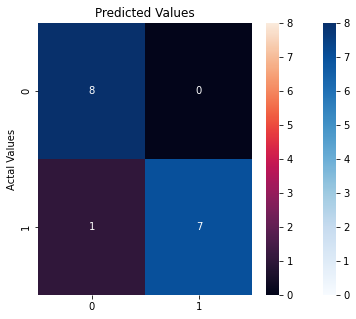

In [108]:
cfm_resnet_v2 = confusion_matrix(tst_lb_bin.argmax(axis=1), pred_resnet_v2.argmax(axis=1))
make_confusion_matrix(cfm_resnet_v2)

In [109]:
pred_resnet_v2

array([[0.7785599 , 0.22144006],
       [0.83779156, 0.16220851],
       [0.9127458 , 0.08725431],
       [0.8634305 , 0.13656949],
       [0.8548566 , 0.14514339],
       [0.83135563, 0.16864437],
       [0.69645566, 0.3035443 ],
       [0.7835162 , 0.21648382],
       [0.02468858, 0.97531146],
       [0.09435897, 0.9056411 ],
       [0.11919009, 0.8808099 ],
       [0.30515224, 0.69484776],
       [0.7267732 , 0.27322686],
       [0.05700263, 0.94299746],
       [0.00702442, 0.9929756 ],
       [0.00135454, 0.9986455 ]], dtype=float32)

In [118]:
def get_inf_data(loc, height, width):
    (inf_data, _) = image_loader(loc, height, width)
    inf_data = inf_data.astype("float") / 255.0 
    return inf_data

In [130]:
def predict(img_data):
    return resnet_v2_pre.predict(img_data, batch_size=4)

In [148]:
def display(pred, filename):
    title = ''
    if pred[0] > pred[1]:
        title = 'Passport'
    else:
        title = 'Drivers Licence'
    
    image = cv2.imread(filename)
    plt_imshow(title, image)

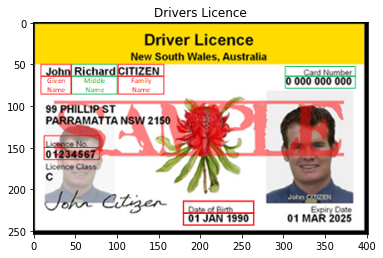

In [155]:
img_1 = get_inf_data("./drv_lc_detection/inference/1", image_height, image_width)
pred_1 = predict(img_1)
display(pred_1[0], "./drv_lc_detection/inference/1/1.png")

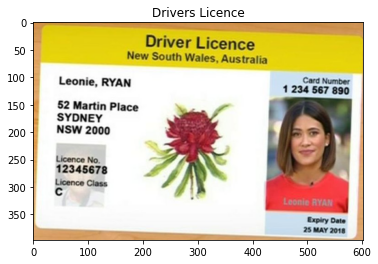

In [156]:
img_16 = get_inf_data("./drv_lc_detection/inference/16", image_height, image_width)
pred_16 = predict(img_16)
display(pred_16[0], "./drv_lc_detection/inference/16/16.png")

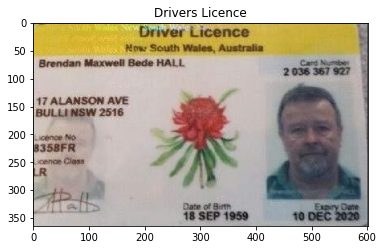

In [157]:
img_22 = get_inf_data("./drv_lc_detection/inference/22", image_height, image_width)
pred_22 = predict(img_22)
display(pred_22[0], "./drv_lc_detection/inference/22/22.png")

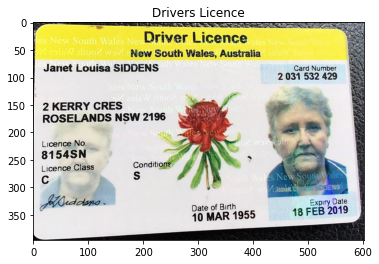

In [158]:
img_24 = get_inf_data("./drv_lc_detection/inference/24", image_height, image_width)
pred_24 = predict(img_24)
display(pred_24[0], "./drv_lc_detection/inference/24/24.png")

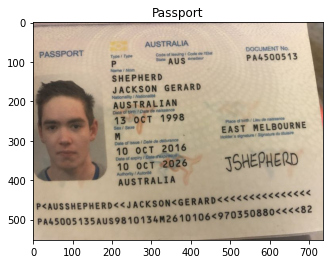

In [159]:
img_28 = get_inf_data("./drv_lc_detection/inference/28", image_height, image_width)
pred_28 = predict(img_28)
display(pred_28[0], "./drv_lc_detection/inference/28/28.png")

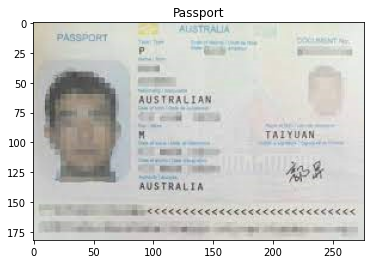

In [160]:
img_32 = get_inf_data("./drv_lc_detection/inference/32", image_height, image_width)
pred_32 = predict(img_32)
display(pred_32[0], "./drv_lc_detection/inference/32/32.png")

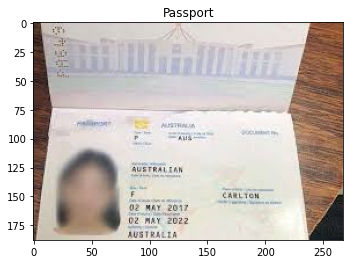

In [161]:
img_34 = get_inf_data("./drv_lc_detection/inference/34", image_height, image_width)
pred_34 = predict(img_34)
display(pred_34[0], "./drv_lc_detection/inference/34/34.png")

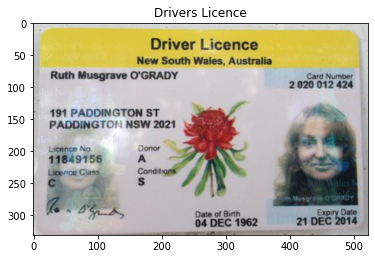

In [162]:
img_35 = get_inf_data("./drv_lc_detection/inference/35", image_height, image_width)
pred_35 = predict(img_35)
display(pred_35[0], "./drv_lc_detection/inference/35/35.png")

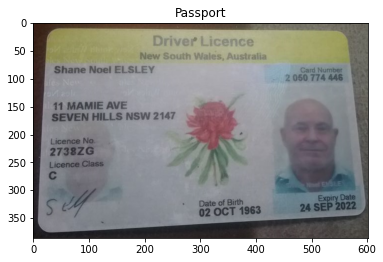

In [163]:
img_37 = get_inf_data("./drv_lc_detection/inference/37", image_height, image_width)
pred_37 = predict(img_37)
display(pred_37[0], "./drv_lc_detection/inference/37/37.png")

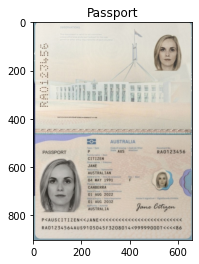

In [164]:
img_38 = get_inf_data("./drv_lc_detection/inference/38", image_height, image_width)
pred_38 = predict(img_38)
display(pred_38[0], "./drv_lc_detection/inference/38/38.png")

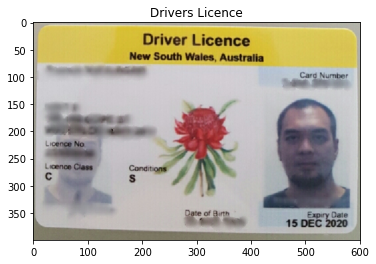

In [165]:
img_39 = get_inf_data("./drv_lc_detection/inference/39", image_height, image_width)
pred_39 = predict(img_39)
display(pred_39[0], "./drv_lc_detection/inference/39/39.png")

In [110]:
(inf_data, _) = image_loader("./drv_lc_detection/inference", image_height, image_width)
inf_data = inf_data.astype("float") / 255.0

In [111]:
inf_resnet_v2 = resnet_v2_pre.predict(inf_data, batch_size=4)

In [112]:
inf_resnet_v2

array([[0.0246886 , 0.97531134]], dtype=float32)

In [113]:
from imutils import contours
import matplotlib.pyplot as plt
import numpy as np
import argparse
import imutils
import cv2

In [114]:
def plt_imshow(title, image):
  # convert the image frame BGR to RGB color space and display it
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.imshow(image)
    plt.title(title)
    plt.grid(False)
    plt.show()

In [115]:
file_list_inf = ['./drv_lc_detection/inference/16.png']

In [101]:
# file_list_inf = ['./drv_lc_detection/inference/1.png', 
#                  './drv_lc_detection/inference/16.png', 
#                  './drv_lc_detection/inference/22.png', 
#                  './drv_lc_detection/inference/24.png', 
#                  './drv_lc_detection/inference/28.png', 
#                  './drv_lc_detection/inference/32.png', 
#                  './drv_lc_detection/inference/34.png', 
#                  './drv_lc_detection/inference/35.png', 
#                  './drv_lc_detection/inference/37.png',
#                  './drv_lc_detection/inference/38.png',
#                 ]

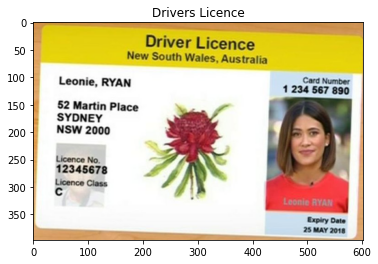

In [117]:
for pred, file in zip(inf_resnet_v2, file_list_inf):
    title = ''
    if pred[0] > pred[1]:
        title = 'Passport'
    else:
        title = 'Drivers Licence'
    
    image = cv2.imread(file)
    plt_imshow(title, image)

In [ ]:
def get_pred_class_name():
    

In [75]:
import glob

files = glob.glob('./drv_lc_detection/inference/*.png', recursive=True)


In [76]:
files

['./drv_lc_detection/inference/28.png',
 './drv_lc_detection/inference/16.png',
 './drv_lc_detection/inference/38.png',
 './drv_lc_detection/inference/34.png',
 './drv_lc_detection/inference/22.png',
 './drv_lc_detection/inference/32.png',
 './drv_lc_detection/inference/24.png',
 './drv_lc_detection/inference/1.png']

In [65]:
files = files_reversed.reverse()

In [68]:
files_reversed

['./drv_lc_detection/testing/drivers_licence/1.png',
 './drv_lc_detection/testing/drivers_licence/24.png',
 './drv_lc_detection/testing/drivers_licence/27.png',
 './drv_lc_detection/testing/drivers_licence/37.png',
 './drv_lc_detection/testing/drivers_licence/22.png',
 './drv_lc_detection/testing/drivers_licence/35.png',
 './drv_lc_detection/testing/drivers_licence/39.png',
 './drv_lc_detection/testing/drivers_licence/16.png',
 './drv_lc_detection/testing/passport/0.png',
 './drv_lc_detection/testing/passport/1.png',
 './drv_lc_detection/testing/passport/26.png',
 './drv_lc_detection/testing/passport/32.png',
 './drv_lc_detection/testing/passport/34.png',
 './drv_lc_detection/testing/passport/38.png',
 './drv_lc_detection/testing/passport/12.png',
 './drv_lc_detection/testing/passport/28.png']

In [59]:
import os

# folder path
dir_path = './drv_lc_detection/testing/drivers_licence'

# list to store files
res = []

# Iterate directory
for path in os.listdir(dir_path):
    # check if current path is a file
    if os.path.isfile(os.path.join(dir_path, path)):
        res.append(path)
print(res)

['.DS_Store']
